In [221]:
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [162]:
data_path = os.path.join(os.getcwd(), "final_rawcounts_merged.csv")
print(data_path)

/Users/gautam/Downloads/KU_Leuven_Bioinformatics_Masters/datathon_ambulance/final_rawcounts_merged.csv


In [231]:
# Read data
data = pd.read_csv(data_path)
#data = data.iloc[:, 1:8]
#data = data.iloc[:, data.columns != 'municipality']
# data['y'] = data['DOA_cardiac_count'] / data['population']
data['DOA_all_count'] = data['DOA_all_count'] / data['population']
data['aed_count'] = data['aed_count'] / data['population']
data['cardiac_intervention_count'] = data['cardiac_intervention_count'] / data['interventions_count']
data['interventions_count'] = data['interventions_count'] / data['population']
data['DOA_cardiac_count'] = data['DOA_cardiac_count'] / data['population']

#X = data.drop(columns = ['postal_code', 'DOA_cardiac'])
#y = data['DOA_cardiac']
X = data.iloc[:, [2, 3, 5, 6, 7]]
y = data.iloc[:, 4]

In [233]:
X

,avg_intervention_time,cardiac_intervention_count,DOA_all_count,interventions_count,aed_count
0,219.142107,0.238092,0.000900,0.164231,0.006254
1,305.541667,0.000000,0.000000,0.000010,0.000000
2,67.550000,0.000000,0.000000,0.000005,0.000000
3,271.019105,0.271499,0.000185,0.033517,0.000242
4,206.805989,0.281693,0.000658,0.083663,0.000612
...,...,...,...,...,...
312,1219.000000,0.000000,0.000000,0.000011,0.000278
313,1233.000000,0.000000,0.000000,0.000191,0.000572
314,2589.520548,0.904110,0.000115,0.004205,0.000518
315,1298.536878,0.910806,0.000886,0.021533,0.000923


In [156]:
data_pca = PCA(n_components=4)
data_pca.fit(X.iloc[:, [0, 1, 2, 3]])
print(data_pca.explained_variance_ratio_)
print(data_pca.components_)

[8.22430978e-01 1.59434475e-01 1.81345475e-02 1.77684441e-13]
[[-1.16942083e-01  2.78230086e-01  9.53369062e-01  9.50269700e-08]
 [ 9.92999852e-01  4.88106157e-02  1.07558440e-01  1.66780234e-07]
 [-1.66085368e-02  9.59273445e-01 -2.81990450e-01 -4.31742744e-07]
 [-1.61670711e-07  3.79579341e-07 -2.30281725e-07  1.00000000e+00]]


In [238]:
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = MinMaxScaler()
scaler.fit(pd.DataFrame(X_train_raw['avg_intervention_time']))
X_train = copy.deepcopy(X_train_raw).drop(columns = 'avg_intervention_time')
X_train['avg_intervention_time'] = scaler.transform(pd.DataFrame(X_train_raw['avg_intervention_time']))
X_test = copy.deepcopy(X_test_raw).drop(columns = 'avg_intervention_time')
X_test['avg_intervention_time'] = scaler.transform(pd.DataFrame(X_test_raw['avg_intervention_time']))
# scaler2 = StandardScaler()
# scaler2.fit(pd.DataFrame(y_train_raw))
# y_train = scaler2.transform(pd.DataFrame(y_train_raw))
# y_test = scaler2.transform(pd.DataFrame(y_test_raw))

In [239]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train_raw.to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test_raw.to_numpy(), dtype=torch.float32).reshape(-1, 1)

In [244]:
# Define the model
model = nn.Sequential(
    nn.Linear(5, 24), # 7 input variables
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    # nn.ReLU(),
    #nn.Linear(12, 6),
    #nn.ReLU(),
    nn.Linear(6, 1) # 1 output (regression)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

batch_size = 10  # size of each batch
n_epochs = int(np.ceil(X_train.shape[0] / 10))
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

In [245]:
n_epochs

23

In [246]:
# Train model
for epoch in range(n_epochs):
    model.train()
    # This next part is just for showing a progress meter; not super important
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

MSE: 4.2684177969931625e-06
RMSE: 0.0020660149556557335


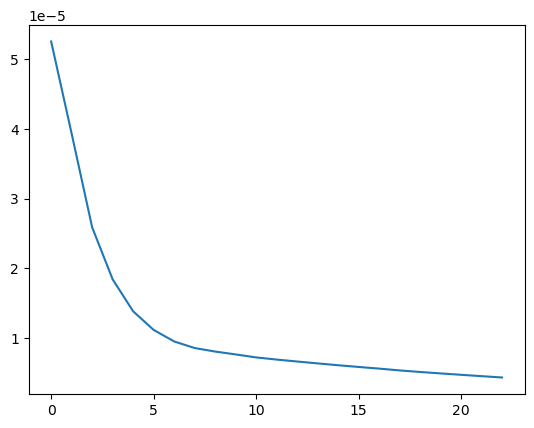

Sequential(
  (0): Linear(in_features=5, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=1, bias=True)
)

In [247]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE:", best_mse)
print("RMSE:", np.sqrt(best_mse))
plt.plot(history)
plt.show()

model.eval()
# with torch.no_grad():
#     # Test out inference with 5 samples from the original test set
#     for i in range(5):
#         X_sample = X_test_raw[i: i+1]
#         X_sample = scaler.transform(X_sample)
#         X_sample = torch.tensor(X_sample, dtype=torch.float32)
#         y_pred = model(X_sample)
#         print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

In [249]:
#test_scaled = scaler.transform(X_test_raw)
y_pred = model(X_test)

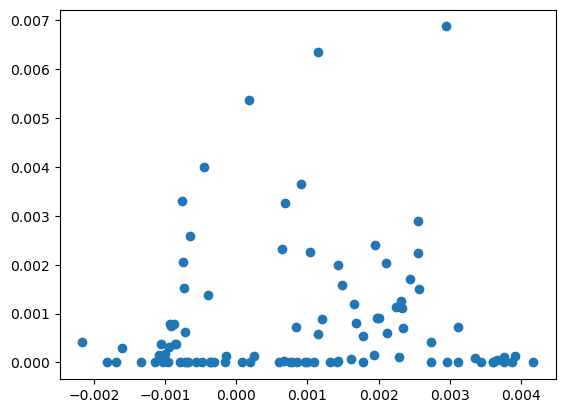

In [257]:
plt.scatter(y_pred.detach().numpy(), y_test.detach().numpy())

In [ ]:
def score_trained_model(params, args):
    # Get the model from the fixed args.
    model = args[0]

    # Run the model on the params, return the output.
    return model_predict(model, params)

In [ ]:
# Nelder-Mead is my go-to to start with.
# But it doesn't take advantage of the gradient.
# Something that does, e.g. BGFS, may perform better for your case.
method = 'Nelder-Mead'

# All zeros is fine, but improving this initial guess can help.
guess_params = [0]*4

# Given a trained model, optimize the inputs to minimize the output.
optim_params = scipy.optimize.minimize(
    score_trained_model,
    guess_params,
    args=(trained_model,),
    method=method,
)

In [263]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train.detach().numpy(), y_train.detach().numpy().ravel())
pred = clf.predict(X_test)

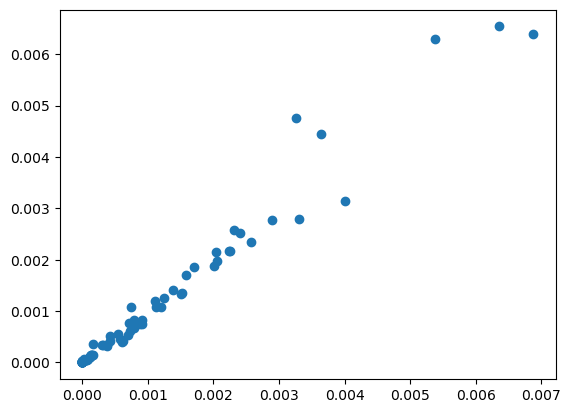

In [264]:
plt.scatter(y_test.detach().numpy(), pred)